In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

# Загрузка данных
data = pd.read_csv('./famcs_students.csv')

# Label Encoding для всех строковых колонок
data_encoded = data.copy()
string_cols = data.select_dtypes(include=['object']).columns

for col in string_cols:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data[col])

In [2]:
data_encoded.head()

,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,1,1,20.0,1,0,1,0,0,...,2,2,3.0,0,48.0,2,9.2,0,1,0
1,4,11,1,0,20.0,1,1,1,1,1,...,2,1,5.0,0,39.0,1,8.8,0,1,0
2,4,11,1,0,19.0,1,1,1,0,1,...,2,0,10.0,0,41.0,2,8.8,0,1,0
3,4,11,1,0,20.0,1,0,1,0,0,...,2,1,3.0,0,36.0,2,8.8,0,1,0
4,4,11,1,1,20.0,1,0,2,0,1,...,0,0,1.0,0,46.0,1,9.0,0,1,0


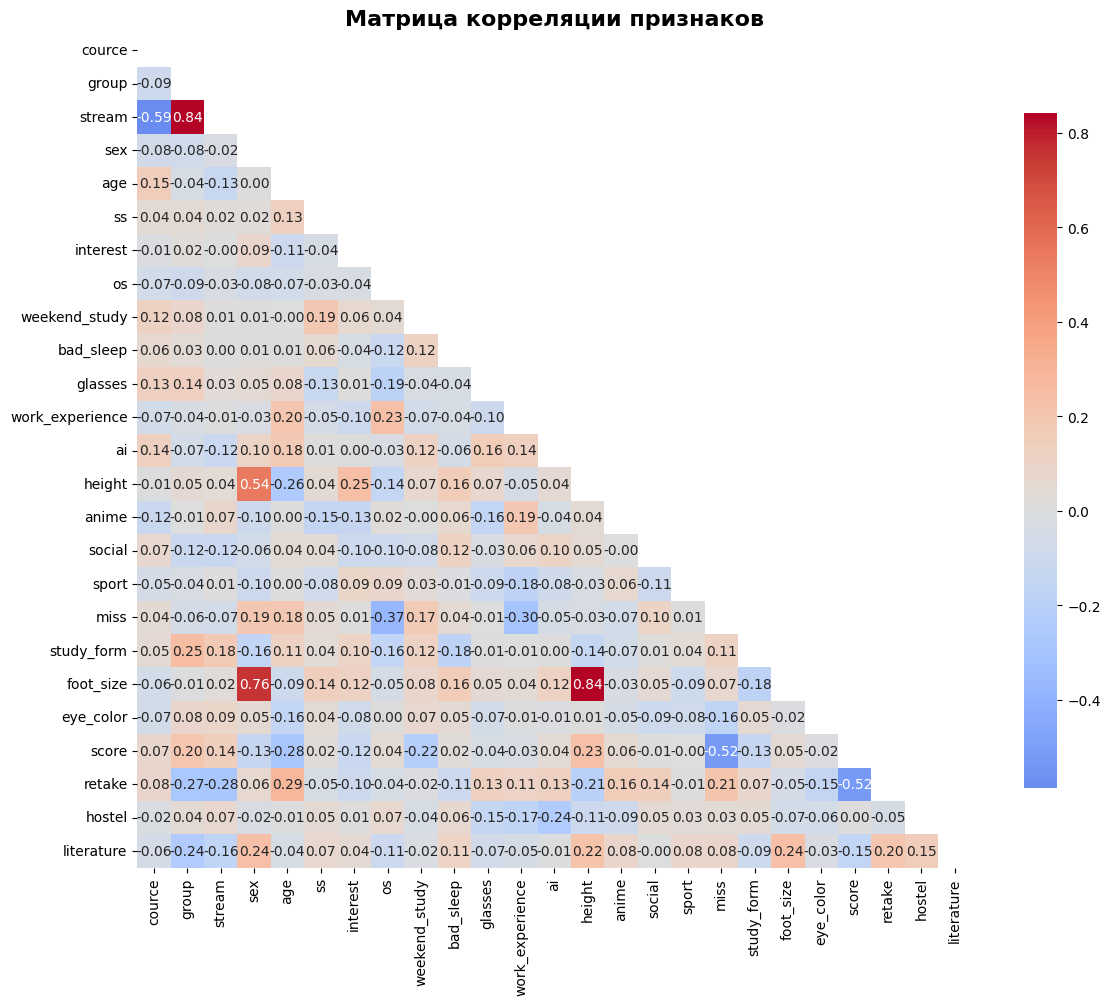

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

correlation_matrix = data_encoded.corr()

plt.figure(figsize=(12, 10))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) 

sns.heatmap(correlation_matrix, 
            mask=mask,  
            annot=True, 
            fmt='.2f',   
            cmap='coolwarm',  
            center=0,    
            square=True,
            cbar_kws={'shrink': 0.8})

plt.title('Матрица корреляции признаков', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

ИСХОДНОЕ РАСПРЕДЕЛЕНИЕ КЛАССОВ:
Класс 0: 99 samples (78.0%)
Класс 1: 28 samples (22.0%)

СБАЛАНСИРОВАННОЕ РАСПРЕДЕЛЕНИЕ КЛАССОВ:
Класс 0: 99 samples (50.0%)
Класс 1: 99 samples (50.0%)


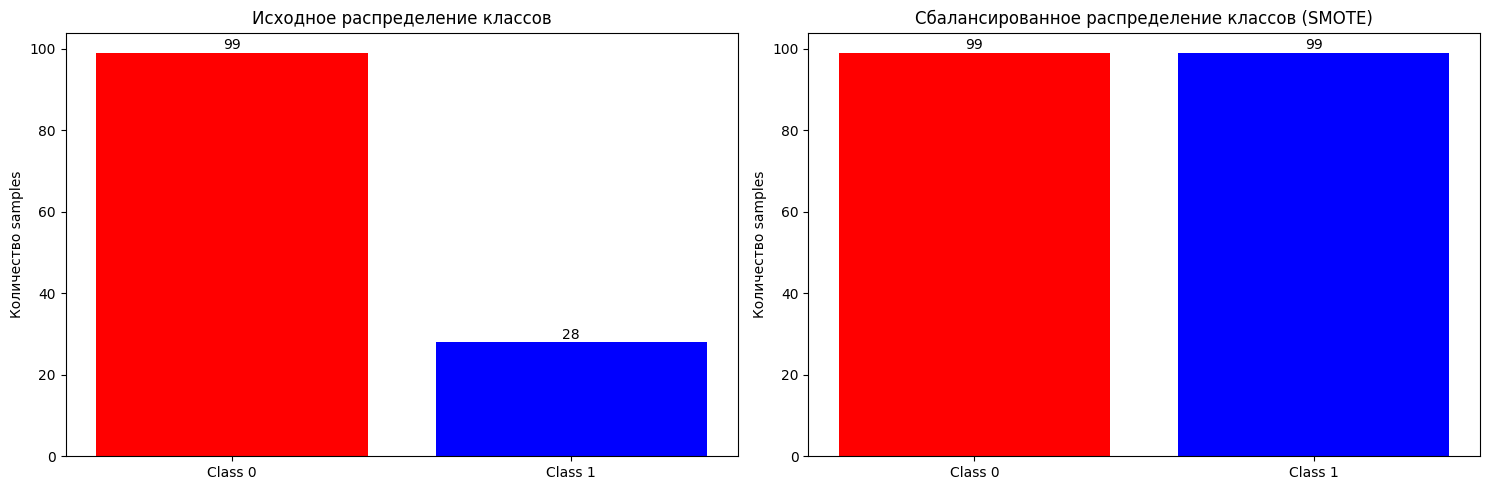


РАЗМЕРЫ СБАЛАНСИРОВАННЫХ ВЫБОРОК:
Тренировочная: 138 samples
Валидационная: 30 samples
Тестовая: 30 samples

РАСПРЕДЕЛЕНИЕ В СБАЛАНСИРОВАННЫХ ВЫБОРКАХ:
Train: Counter({0: 69, 1: 69})
Val: Counter({1: 15, 0: 15})
Test: Counter({0: 15, 1: 15})


In [4]:
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
N = 2
target_column = binary_cols[N % 8]

selected_columns = ['score', 'study_form', 'miss', 'bad_sleep', 'work_experience']

X = data_encoded[selected_columns]
y = data_encoded[target_column]

print("ИСХОДНОЕ РАСПРЕДЕЛЕНИЕ КЛАССОВ:")
original_dist = Counter(y)
print(f"Класс 0: {original_dist[0]} samples ({original_dist[0]/len(y)*100:.1f}%)")
print(f"Класс 1: {original_dist[1]} samples ({original_dist[1]/len(y)*100:.1f}%)")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(['Class 0', 'Class 1'], [original_dist[0], original_dist[1]], color=['red', 'blue'])
plt.title('Исходное распределение классов')
plt.ylabel('Количество samples')
for i, v in enumerate([original_dist[0], original_dist[1]]):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("\nСБАЛАНСИРОВАННОЕ РАСПРЕДЕЛЕНИЕ КЛАССОВ:")
balanced_dist = Counter(y_balanced)
print(f"Класс 0: {balanced_dist[0]} samples ({balanced_dist[0]/len(y_balanced)*100:.1f}%)")
print(f"Класс 1: {balanced_dist[1]} samples ({balanced_dist[1]/len(y_balanced)*100:.1f}%)")

plt.subplot(1, 2, 2)
plt.bar(['Class 0', 'Class 1'], [balanced_dist[0], balanced_dist[1]], color=['red', 'blue'])
plt.title('Сбалансированное распределение классов (SMOTE)')
plt.ylabel('Количество samples')
for i, v in enumerate([balanced_dist[0], balanced_dist[1]]):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

X_temp, X_test, y_temp, y_test = train_test_split(X_balanced, y_balanced, test_size=0.15, random_state=42, stratify=y_balanced)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

print(f"\nРАЗМЕРЫ СБАЛАНСИРОВАННЫХ ВЫБОРОК:")
print(f"Тренировочная: {X_train.shape[0]} samples")
print(f"Валидационная: {X_val.shape[0]} samples")
print(f"Тестовая: {X_test.shape[0]} samples")

print(f"\nРАСПРЕДЕЛЕНИЕ В СБАЛАНСИРОВАННЫХ ВЫБОРКАХ:")
print(f"Train: {Counter(y_train)}")
print(f"Val: {Counter(y_val)}")
print(f"Test: {Counter(y_test)}")

## 0. Тривиальный класификатор

In [5]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

## 1. Наивный байесовский классификатор

In [23]:
import numpy as np

class NaiveBayesClassifier:
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing
        self.class_priors = {}
        self.class_stats = {}
        self.classes_ = None
    
    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y)
        
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        
        for cls in self.classes_:
            mask = (y == cls)
            X_cls = X[mask]
            n_cls = np.sum(mask)
            
            mean = np.mean(X_cls, axis=0)
            var = np.var(X_cls, axis=0, ddof=1)
            var = np.clip(var, self.var_smoothing, None)
            
            self.class_stats[cls] = {
                'mean': mean,
                'var': var,
                'log_var': np.log(var)
            }
            
            self.class_priors[cls] = n_cls / n_samples
        
        self.feature_weights_ = self._compute_feature_weights(X, y)
        return self
    
    def _compute_feature_weights(self, X, y):
        if len(self.classes_) < 2:
            return np.ones(X.shape[1])
        
        weights = np.zeros(X.shape[1])
        overall_mean = np.mean(X, axis=0)
        
        for i in range(X.shape[1]):
            feature_values = X[:, i]
            
            between_var = 0
            for cls in self.classes_:
                mask = (y == cls)
                if np.any(mask):
                    class_mean = np.mean(feature_values[mask])
                    n_cls = np.sum(mask)
                    between_var += n_cls * (class_mean - overall_mean[i]) ** 2
            
            within_var = 0
            for cls in self.classes_:
                mask = (y == cls)
                if np.any(mask):
                    class_values = feature_values[mask]
                    class_mean = np.mean(class_values)
                    within_var += np.sum((class_values - class_mean) ** 2)
            
            if within_var > 0:
                weights[i] = between_var / within_var
            else:
                weights[i] = 1.0
        
        if np.sum(weights) > 0:
            weights = weights / np.sum(weights)
        
        return weights
    
    def _compute_log_likelihood(self, X, mean, var, log_var):
        log_2pi = np.log(2 * np.pi)
        diff = X - mean
        exponent = -0.5 * ((diff ** 2) / var)
        log_probs = -0.5 * (log_2pi + log_var) + exponent
        
        weighted_log_probs = log_probs * self.feature_weights_
        return np.sum(weighted_log_probs, axis=1)
    
    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float64)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        
        log_probs = np.zeros((n_samples, n_classes), dtype=np.float64)
        
        for idx, cls in enumerate(self.classes_):
            stats = self.class_stats[cls]
            log_prior = np.log(self.class_priors[cls])
            log_likelihood = self._compute_log_likelihood(
                X, stats['mean'], stats['var'], stats['log_var']
            )
            log_probs[:, idx] = log_prior + log_likelihood
        
        max_log_probs = np.max(log_probs, axis=1, keepdims=True)
        log_probs_shifted = log_probs - max_log_probs
        exp_probs = np.exp(log_probs_shifted)
        
        proba = exp_probs / np.sum(exp_probs, axis=1, keepdims=True)
        return proba
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

nb_classifier = NaiveBayesClassifier(0)
nb_classifier.fit(X_train, y_train)

y_val_proba = nb_classifier.predict_proba(X_val)

## 2. Метод k-ближайших соседей

In [7]:
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score

class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X.values if hasattr(X, 'values') else X
        self.y_train = y.values if hasattr(y, 'values') else y
    
    def _calculate_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def predict(self, X):
        X_test = X.values if hasattr(X, 'values') else X
        predictions = []
        
        for test_sample in X_test:
            distances = []
            for i, train_sample in enumerate(self.X_train):
                dist = self._calculate_distance(test_sample, train_sample)
                distances.append((dist, self.y_train[i]))
            
            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]
            
            k_nearest_labels = [label for _, label in k_nearest]
            most_common = Counter(k_nearest_labels).most_common(1)
            predictions.append(most_common[0][0])
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        X_test = X.values if hasattr(X, 'values') else X
        probabilities = []
        
        for test_sample in X_test:
            distances = []
            for i, train_sample in enumerate(self.X_train):
                dist = self._calculate_distance(test_sample, train_sample)
                distances.append((dist, self.y_train[i]))
            
            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]
            k_nearest_labels = [label for _, label in k_nearest]
            
            label_counts = Counter(k_nearest_labels)
            prob = [label_counts.get(label, 0) / self.k for label in np.unique(self.y_train)]
            probabilities.append(prob)
        
        return np.array(probabilities)
best_k = 1
best_val_accuracy = 0
k_values = range(1, 16, 2) 

results = []

for k in k_values:
    knn = KNNClassifier(k=k) 
    knn.fit(X_train, y_train)
    
    y_val_pred_knn = knn.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred_knn)
    
    results.append((k, val_accuracy))
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_k = k

knn = KNNClassifier(k=best_k) 
knn.fit(X_train, y_train)
print(f"\nОптимальный k: {best_k} (точность: {best_val_accuracy:.4f})")


Оптимальный k: 1 (точность: 0.8333)


## 3. Логистическая регрессия

Оптимальный порог: 0.384
F1-score при оптимальном пороге: 0.750
Precision при оптимальном пороге: 0.600
Recall при оптимальном пороге: 1.000


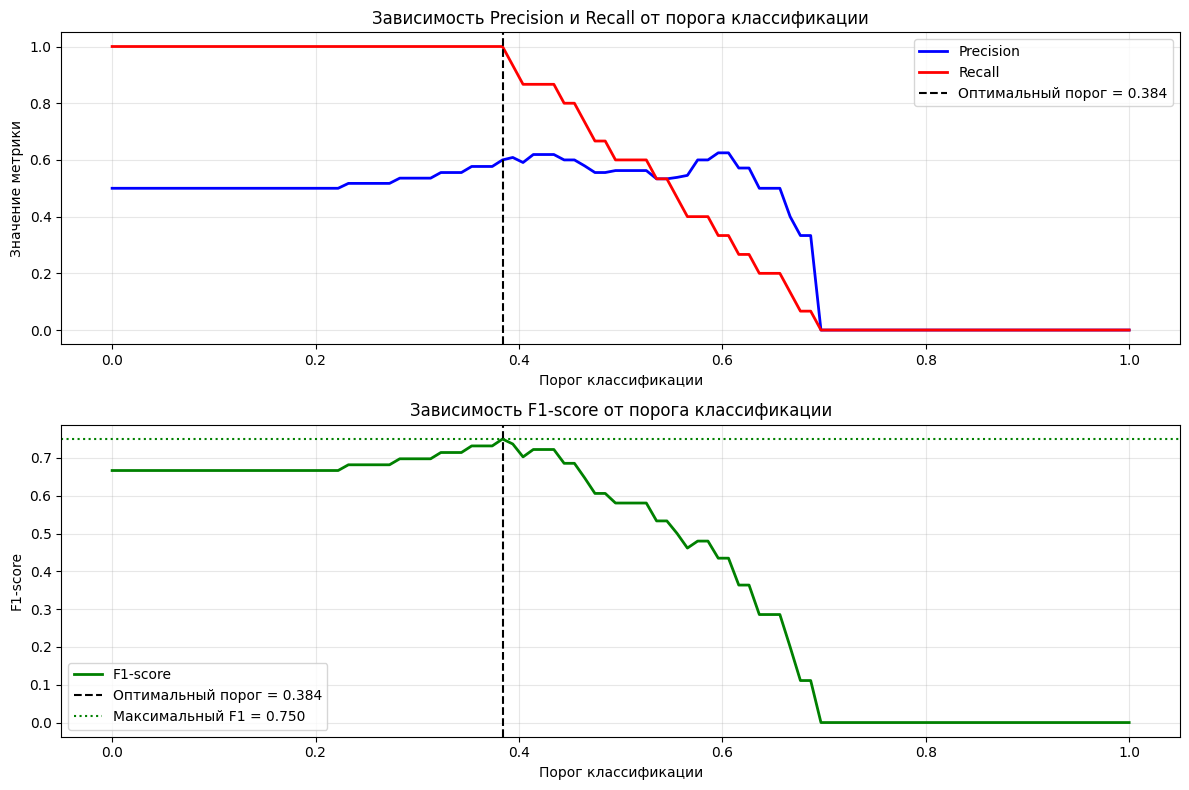


Результаты на тестовой выборке с оптимальным порогом:
Precision: 0.522
Recall: 0.800
F1-score: 0.632


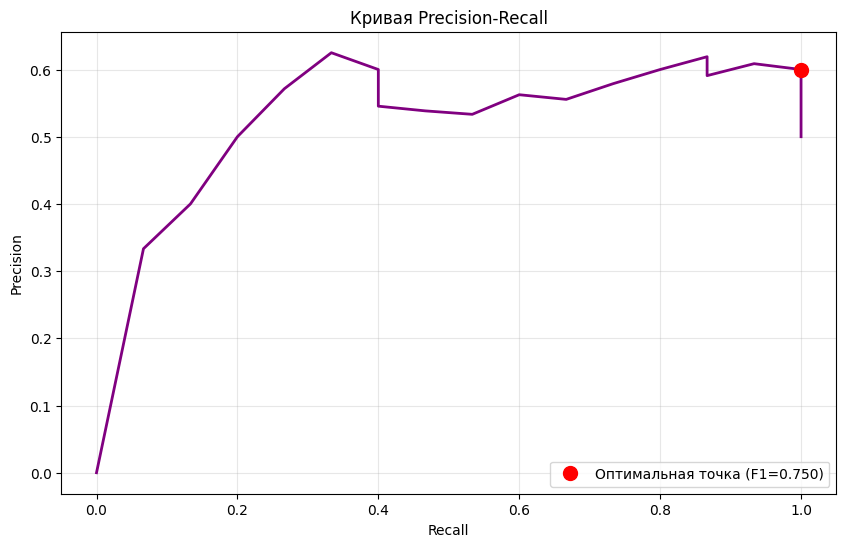

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler

class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000, regularization=0.1):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.regularization = regularization
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _compute_loss(self, y, y_pred):
        epsilon = 1e-8
        loss = -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
        if self.weights is not None:
            loss += 0.5 * self.regularization * np.sum(self.weights ** 2)
        return loss
    
    def _initialize_parameters(self, n_features):
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0.0
        
    def fit(self, X, y, verbose=False):
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        n_samples, n_features = X_scaled.shape
        self._initialize_parameters(n_features)
        
        for iteration in range(self.n_iter):
            linear_output = np.dot(X_scaled, self.weights) + self.bias
            y_pred = self._sigmoid(linear_output)
            
            error = y_pred - y
            dw = (1 / n_samples) * np.dot(X_scaled.T, error) + (self.regularization / n_samples) * self.weights
            db = (1 / n_samples) * np.sum(error)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            train_loss = self._compute_loss(y, y_pred)
            self.loss_history.append(train_loss)
            
            if verbose and iteration % 100 == 0:
                print(f"Iter {iteration}: Train Loss = {train_loss:.4f}")
    
    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        linear_output = np.dot(X_scaled, self.weights) + self.bias
        return self._sigmoid(linear_output)
    
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)
    
    def get_coefficients(self):
        return self.weights, self.bias
    
    def plot_training_history(self):
        plt.figure(figsize=(8, 4))
        plt.plot(self.loss_history)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.grid(True, alpha=0.3)
        plt.show()

model = CustomLogisticRegression(
    learning_rate=0.1,
    n_iter=2000,
    regularization=0.5
)

model.fit(X_train, y_train)

y_val_proba = model.predict_proba(X_val)

def evaluate_thresholds(probabilities, y_true, thresholds):
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (probabilities >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    return precisions, recalls, f1_scores

thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1_scores = evaluate_thresholds(y_val_proba, y_val, thresholds)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]

print(f"Оптимальный порог: {best_threshold:.3f}")
print(f"F1-score при оптимальном пороге: {best_f1:.3f}")
print(f"Precision при оптимальном пороге: {best_precision:.3f}")
print(f"Recall при оптимальном пороге: {best_recall:.3f}")

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
plt.plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
plt.axvline(x=best_threshold, color='k', linestyle='--', 
           label=f'Оптимальный порог = {best_threshold:.3f}')
plt.xlabel('Порог классификации')
plt.ylabel('Значение метрики')
plt.title('Зависимость Precision и Recall от порога классификации')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(thresholds, f1_scores, 'g-', label='F1-score', linewidth=2)
plt.axvline(x=best_threshold, color='k', linestyle='--', 
           label=f'Оптимальный порог = {best_threshold:.3f}')
plt.axhline(y=best_f1, color='g', linestyle=':', 
           label=f'Максимальный F1 = {best_f1:.3f}')
plt.xlabel('Порог классификации')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от порога классификации')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

y_test_pred_optimal = model.predict(X_test, threshold=best_threshold)
test_precision = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall = recall_score(y_test, y_test_pred_optimal, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred_optimal, zero_division=0)

print("\nРезультаты на тестовой выборке с оптимальным порогом:")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1-score: {test_f1:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'purple', linewidth=2)
plt.plot(best_recall, best_precision, 'ro', markersize=10, 
         label=f'Оптимальная точка (F1={best_f1:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Оценка качества

ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ

Сводная таблица метрик:
                     accuracy  precision  recall  f1_score  roc_auc
dummy_clf              0.5000     0.0000  0.0000    0.0000   0.5000
nb_classifier          0.5667     0.5714  0.5333    0.5517   0.5511
knn                    0.7667     0.7222  0.8667    0.7879   0.7667
logistic_regression    0.7333     0.7692  0.6667    0.7143   0.7333


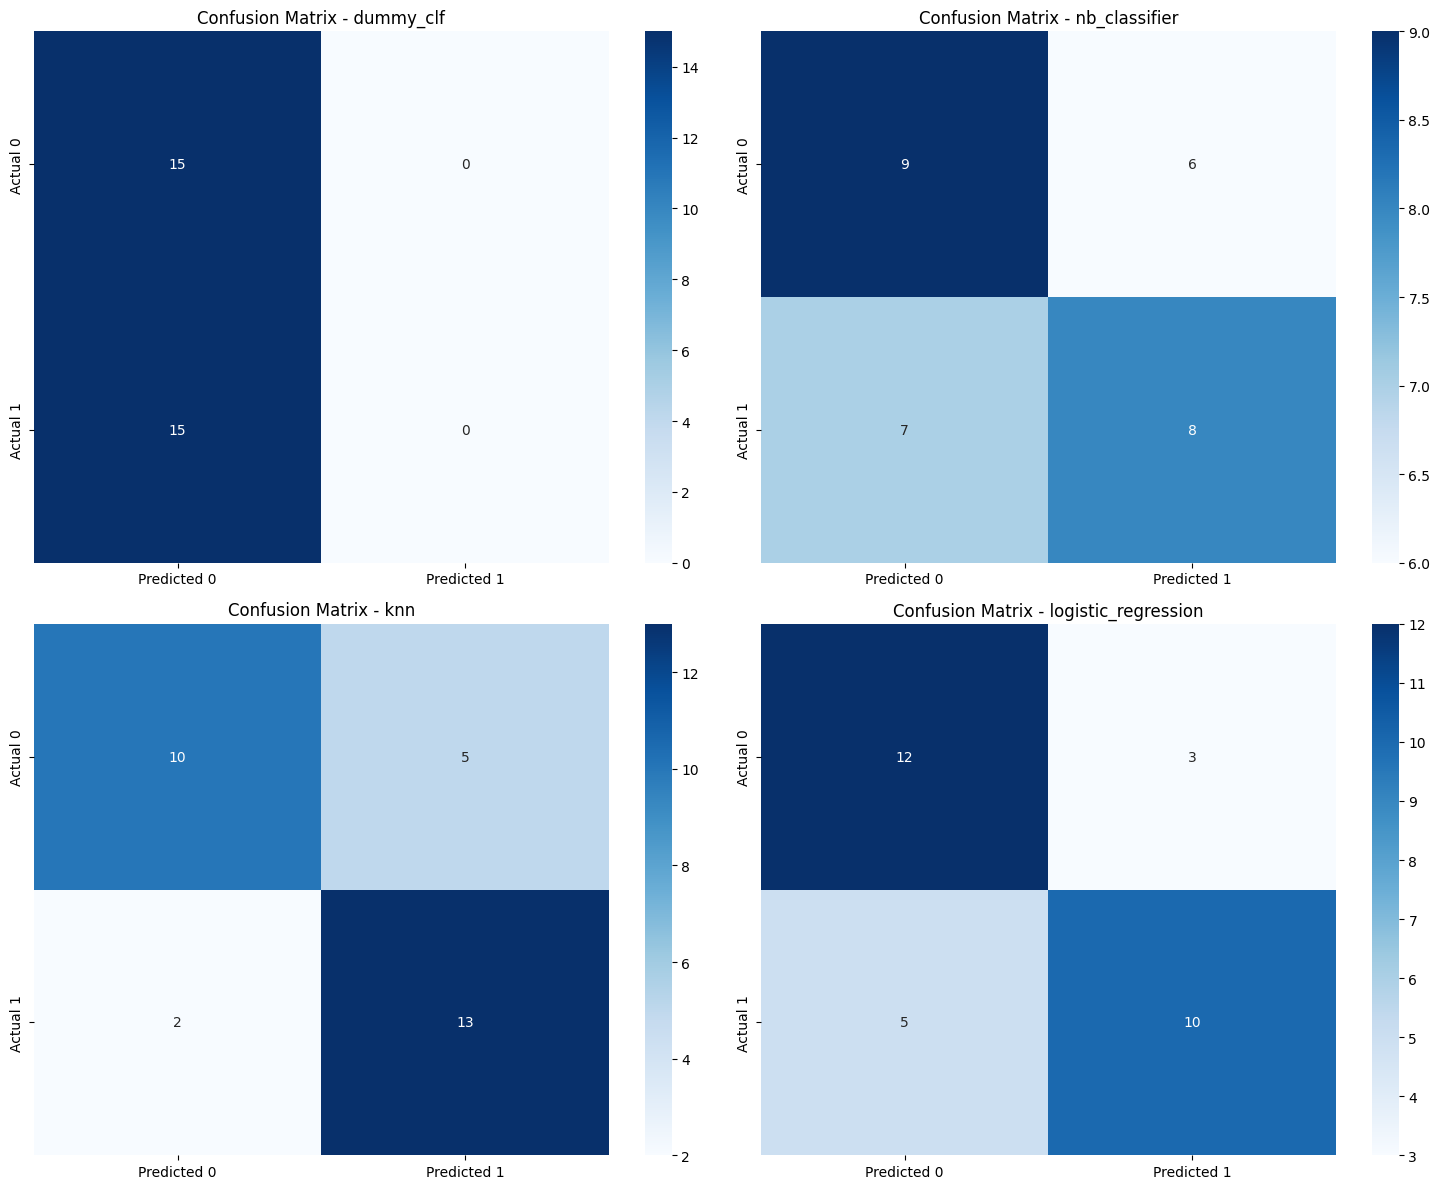

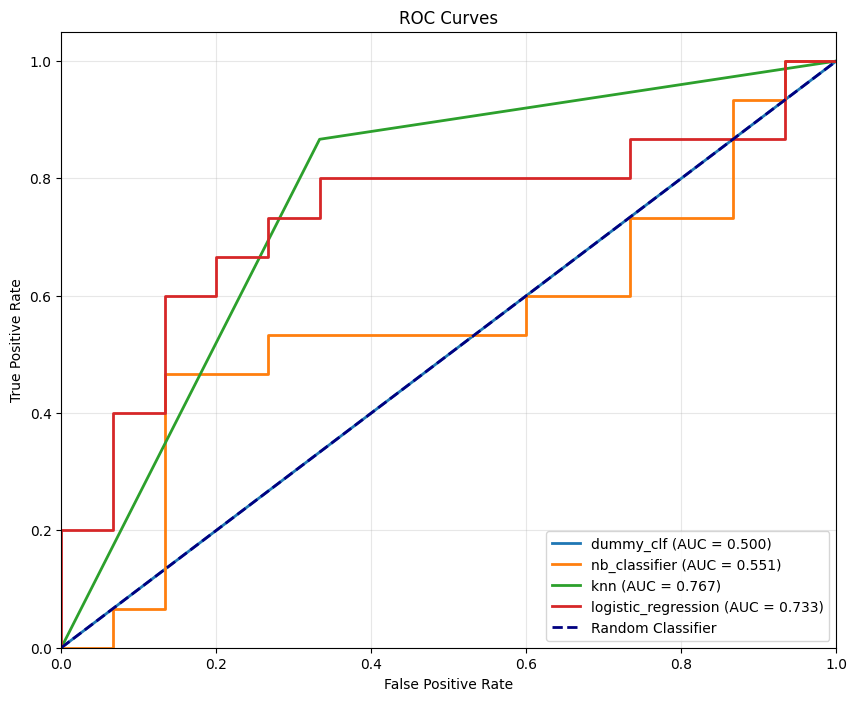

ДЕТАЛЬНЫЕ ОТЧЕТЫ ПО КЛАССИФИКАЦИИ

DUMMY_CLF - Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.50      1.00      0.67        15
     Class 1       0.00      0.00      0.00        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30


NB_CLASSIFIER - Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.56      0.60      0.58        15
     Class 1       0.57      0.53      0.55        15

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.57        30
weighted avg       0.57      0.57      0.57        30


KNN - Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, f1_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def evaluate_models(models_dict, X_test, y_test, model_names=None):
    results = {}
    predictions = {}
    
    print("ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ")
    
    for name, model in models_dict.items():
        y_pred = model.predict(X_test)
        
        y_pred_proba = None
        roc_auc = None
        
        proba = model.predict_proba(X_test)
        if len(proba.shape) == 2 and proba.shape[1] > 1:
            y_pred_proba = proba[:, 1]  #
        else:
            y_pred_proba = proba  
        if y_pred_proba is not None:
            roc_auc = roc_auc_score(y_test, y_pred_proba)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        }
        
        predictions[name] = {
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
    
    return results, predictions

models = {
    'dummy_clf': dummy_clf,
    'nb_classifier': nb_classifier,
    'knn': knn,
    'logistic_regression': model 
}

results, predictions = evaluate_models(models, X_test, y_test)

metrics_df = pd.DataFrame(results).T
print("\nСводная таблица метрик:")
print(metrics_df.round(4))

def plot_confusion_matrices(models_dict, predictions, y_test):  
    n_models = len(models_dict)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models_dict.items()):
        if idx < len(axes):
            y_pred = predictions[name]['y_pred']
            cm = confusion_matrix(y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                       xticklabels=['Predicted 0', 'Predicted 1'],
                       yticklabels=['Actual 0', 'Actual 1'])
            axes[idx].set_title(f'Confusion Matrix - {name}')
    
    for idx in range(n_models, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(models, predictions, y_test)

def plot_roc_curves(models_dict, predictions, y_test):
    """Построение ROC-кривых для моделей с вероятностями"""
    
    plt.figure(figsize=(10, 8))
    
    models_with_proba = []
    
    for name, model in models_dict.items():
        y_pred_proba = predictions[name]['y_pred_proba']
        if y_pred_proba is not None:
            try:
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                
                plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
                models_with_proba.append(name)
            except Exception as e:
                print(f"Ошибка при построении ROC для {name}: {e}")
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_roc_curves(models, predictions, y_test)

def detailed_classification_reports(models_dict, predictions, y_test):
    
    print("=" * 80)
    print("ДЕТАЛЬНЫЕ ОТЧЕТЫ ПО КЛАССИФИКАЦИИ")
    print("=" * 80)
    
    for name, model in models_dict.items():
        print(f"\n{name.upper()} - Classification Report:")
        print("-" * 50)
        y_pred = predictions[name]['y_pred']
        print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

detailed_classification_reports(models, predictions, y_test)
